<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Exercises/12_Approx-pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook pre steps

In [1]:
#@title Installations
# install missing packages
!pip install -q dfply
!python --version

from dfply import *
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np  # RNG and vector ops
import pandas as pd  # tabular outputs
import math
import random
from IPython.display import display, Markdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 8.1 MB/s eta 0:00:00
Python 3.12.12


# On-policy prediction with approximation

## Example - A Random Walk

Consider a large random walk environment with 1,000 non-terminal states labeled 1 through 1000. Two terminal states lie just outside this range: state 0 on the left, which yields a reward of −1, and state 1001 on the right, which yields a reward of +1. Each episode begins in the center state, 500.  

From any nonterminal state $s$, the agent flips a fair coin to choose left or right, then samples a jump size $k$ uniformly from $\{1, 2, \dots, 100\}$. The agent then moves to state $s - k$ or $s + k$. If the resulting state lies outside $[1,1000]$, the episode terminates immediately with the corresponding terminal reward. All intermediate transitions give a reward of 0. The policy is fixed and uniform. That is, a random policy with $\pi(a|s) = 0.5$ where $a$ is either left or right.

Let us first define the environment:







In [2]:
#@title Environment (non-generic)

class EnvRandomWalk:
    """1,000-state random walk with terminal rewards ±1.

    States are 1..1000 (nonterminal). A step chooses left/right with prob 1/2
    and a jump size k ~ Uniform{1..100}. Stepping <1 yields reward -1 and
    termination; stepping >1000 yields reward +1 and termination.
    """
    def __init__(self, n_states=1000, max_jump=100, start_state=500, rng_seed = None):
        self.n = n_states
        self.max_jump = max_jump
        self.start_state = start_state
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(self.rng_seed)
        self.v_opt = None
        self.dist = None

    def reset(self):
        return self.start_state

    def reset_rng(self):
        self.rng = np.random.default_rng(self.rng_seed)

    def step(self, s: int):
        """
        Takes a step in the environment.

        Args:
            s: The current

        Returns:
            A tuple containing:
                s_next: The next state.
                r: The reward for the transition.
                done: A boolean indicating whether the episode is done.
        """
        k = self.rng.integers(1, self.max_jump + 1)
        direction = -1 if self.rng.random() < 0.5 else 1
        s_next = s + direction * k
        if s_next < 1:
            return s_next, -1.0, True
        if s_next > self.n:
            return s_next, +1.0, True
        return s_next, 0.0, False

    def calc_v_opt(self):
        """
        Calculates the optimal state values under the policy.

        Returns:
            A numpy array representing the optimal state values.
        """
        n = self.n
        A = np.eye(n, dtype=float)
        b = np.zeros(n, dtype=float)
        p_each = 1.0 / (2 * self.max_jump)

        for s in range(1, n + 1):
            row = s - 1
            # Left jumps
            left_overflow = max(0, self.max_jump - (s - 1))
            if left_overflow > 0:
                b[row] += (-1.0) * p_each * left_overflow
            left_max_in = min(self.max_jump, s - 1)
            for k in range(1, left_max_in + 1):
                s2 = s - k
                A[row, s2 - 1] -= p_each
            # Right jumps
            right_overflow = max(0, (s + self.max_jump) - n)
            if right_overflow > 0:
                b[row] += (+1.0) * p_each * right_overflow
            right_max_in = min(self.max_jump, n - s)
            for k in range(1, right_max_in + 1):
                s2 = s + k
                A[row, s2 - 1] -= p_each

        self.v_opt = np.linalg.solve(A, b)

    def calc_on_policy_distribution(self, episodes=100000):
        """
        Calculates the on-policy distribution by simulating episodes.

        Args:
            episodes: The number of episodes to simulate.

        Returns:
            A numpy array representing the empirical on-policy distribution over states.
        """
        # Reset visit counts before simulation
        visit_counts = np.zeros(self.n, dtype=int)
        for _ in range(episodes):
            s = self.reset()
            done = False
            while not done:
                visit_counts[s - 1] += 1
                s, r, done = self.step(s)
        total_visits = visit_counts.sum()
        self.dist = visit_counts / total_visits if total_visits > 0 else np.zeros(self.n)

To calculate the "true" state-value function under the policy, we set $v(0) = -1$ and $v(1001) = 1$. The  Bellman equations (@eq-) then become

$$
\begin{align}
v(s)
    =& \sum_{a} \pi(a|s)(r(s,a) + \sum_{s'} p(s'\mid s,a) v(s')  \\
    =& \sum_{a} \pi(a|s) \sum_{s'\notin T} p(s'\mid s,a) v(s') + \sum_{s' \in T} p(s'\mid s) r(s') \\
    =& \sum_{a} 0.5 \sum_{s'\notin T} p(s'\mid s,a) v(s') + Pr(1001|s) - Pr(0|s)  \\
    =& \sum_{s'\notin T} p(s'\mid s,a) v(s') + Pr(1001|s) - Pr(0|s)
\end{align}
$$

If we move a bit around, we get:
$$
v_s - \sum_{s'\notin T} p(s'\mid s,a) v(s') = Pr(1001|s) - Pr(0|s) \\
$$
That is, to find $v$, we may solve a set of equations $\textbf A\textbf v = \textbf b$ where the entries are
$$
\begin{align}
 b_s =& Pr(1001|s) - Pr(0|s) \\
 A_{s,s'} =& -p(s'\mid s,a) \text{ if } s\neq s'\\
A_{s,s'} =& 1-p(s'\mid s,a) \text{ if } s= s'
\end{align}
$$
This is implemented in a method of the environment and automatically calculated when making an instance of the environment.




In [3]:
env = EnvRandomWalk(rng_seed=3543)
env.calc_on_policy_distribution()
env.calc_v_opt()

Let us make a plot of the true state values ($v_\pi(s)$):

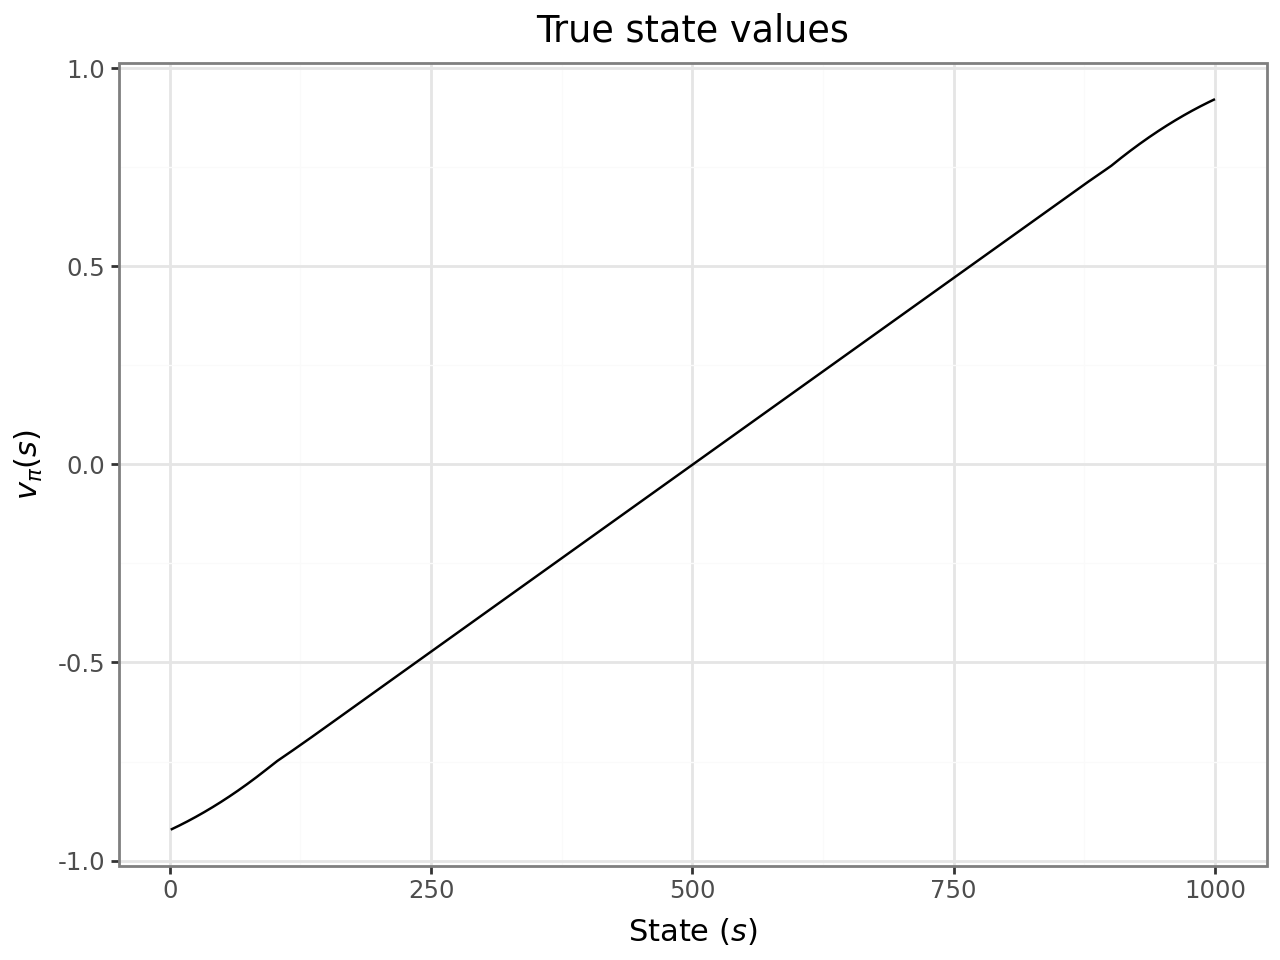

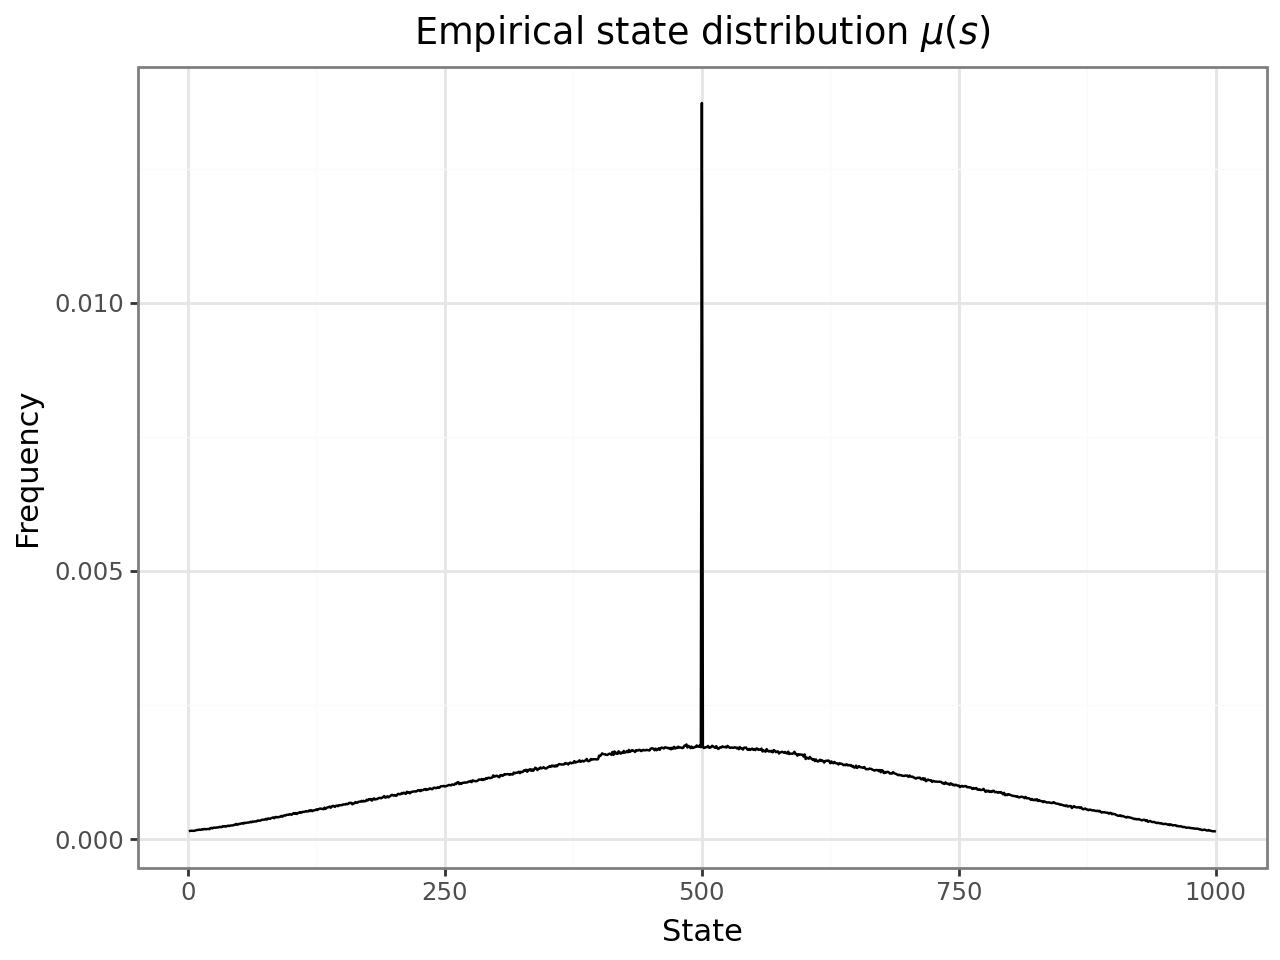

In [4]:
df = pd.DataFrame({'state': range(1, env.n + 1), 'mu': env.dist, 'v_opt': env.v_opt})

pt = (
    ggplot(df, aes(x='state', y='v_opt')) +
    geom_line() +
    labs(title='True state values', x='State ($s$)', y='$v_\\pi(s)$') +
    theme_bw()
)
pt.show()

pt = (
    ggplot(df, aes(x='state', y='mu')) +
    geom_line() +
    labs(title='Empirical state distribution $\\mu(s)$', x='State', y='Frequency') +
    theme_bw()
)
pt.show()


The goal is to estimate this value function $v(s)$ under this policy using function approximation. We will use the example to consider different linear function approximations.

## State aggregation

State aggregation is a special case of linear function approximation in
which states are grouped together, with one estimated value (one
component of the weight vector w) for each group. That is, the value of
a state is estimated as its group’s value.


#### Example - A random walk

The 1000 states are divided into 10 groups, i.e. group $0,\ldots,9$ of 100 consecutive states, and the approximate value function is piecewise constant $\hat v(s; \textbf w) = w_{g(s)}$, where $g(s)$ denotes the index of the group containing state $s$. That is,
$$
g(s)=\left\lfloor\frac{s-1}{100}​\right\rfloor,
$$
and $\textbf w = (w_0, \ldots, w_{9})$ where $w_i$ is the estimated state value of group $i$. This setup produces a piecewise constant approximation due to aggregation.

Learning is performed with gradient Monte Carlo prediction. Each episode yields a return $G$, which is simply the terminal reward. For each visited state $s$ in the episode, the weight of its group is updated according to  

$$
w_{g(s)} \leftarrow w_{g(s)} + \alpha \, (G - w_{g(s)}),
$$
where the step size is $\alpha = 2 \times 10^{-5}$ and the experiment runs for 100,000 episodes.  

Let us make an agent for the problem:

In [ ]:
#@title Agent (parent class)

class AgentApprox:
    """
    An agent for on-policy prediction with linear function approximation for
    the random walk.
    """
    def __init__(self, env, len_w):
        """
        Initializes the AgentApproxAggregation.

        Args:
            env: The environment to interact with.
            groups: The number of groups for state aggregation.
            alpha: The step size for the gradient Monte Carlo update.
        """
        self.env = env
        self.len_w = len_w
        self.w = np.zeros(self.len_w, dtype=float)

    def reset_w(self, val = 0):
        """
        Resets the weights to a given value.

        Args:
            val: The value to reset the weights to.
        """
        self.w.fill(val)

    def gradient(self, s):
        """
        Calculates the gradient for a given state.

        Args:
            s: The state number (1-based).

        Returns:
            A numpy array representing the gradient.
        """
        raise NotImplementedError("Subclasses must implement gradient")

    def gradient_mc_episode(self, alpha):
        """
        Runs a single episode using the current policy and updates the weights
        using gradient Monte Carlo.

        Args:
            alpha: The step size for the gradient Monte Carlo update.
        """
        s = self.env.reset()
        trajectory = []
        done = False
        while not done:
            trajectory.append(s)
            s, r, done = self.env.step(s)
        G = r
        for s_vis in trajectory:
            x_vis = self.gradient(s_vis)
            v_hat = np.dot(self.w, x_vis)
            self.w += alpha * (G - v_hat) * x_vis


    def semi_gradient_td0_episode(self, alpha):
        """
        Runs a single episode using the current policy and updates the weights
        using semi-gradient TD(0).

        Args:
            alpha: The step size for the semi-gradient TD(0) update.
        """
        s = self.env.reset()
        done = False
        while not done:
            s_n, r, done = self.env.step(s)
            x = self.gradient(s)
            v_hat = np.dot(self.w, x)
            if not done:
                x_n = self.gradient(s_n)
                v_hat_n = np.dot(self.w, x_n)
                self.w += alpha * (r + v_hat_n - v_hat) * x
                s = s_n
            else:
                self.w += alpha * (r - v_hat) * x  # state value is 0 for the terminal state


    def calculate_rmsve(self):
        """
        Calculates the Root Mean Squared Weighted Value Error (RMSWVE).
        Assumes that the distribution and optimal state values are calculated
        in the environment.

        Return:
            rmsve: The RMSWVE value.
        """
        v_approx = self.get_approx_values()
        return np.sqrt(np.sum(env.dist * (v_approx - env.v_opt)**2))

    def gradient_mc(self, episodes, alpha, eval_every=1000):
        """
        Runs multiple episodes, updates the weights, and tracks RMSVE using
        gradient Monte Carlo.

        Args:
            episodes: The number of episodes to run.
            eval_every: The number of episodes between RMSVE evaluations.
            alpha: The step size for the gradient Monte Carlo update.

        Returns:
            A tuple containing:
                rmsve_hist: A list of (episode, RMSVE) tuples.
        """
        rmsve_hist = []

        for ep in range(episodes):
            self.gradient_mc_episode(alpha)
            if (ep + 1) % eval_every == 0:
                rmsve = self.calculate_rmsve()
                rmsve_hist.append(((ep + 1), rmsve))

        return rmsve_hist

    def semi_gradient_td0(self, episodes, alpha, eval_every=1000):
        """
        Runs multiple episodes, updates the weights, and tracks RMSVE using
        gradient Monte Carlo.

        Args:
            episodes: The number of episodes to run.
            eval_every: The number of episodes between RMSVE evaluations.
            alpha: The step size for the semi-gradient TD(0) update.

        Returns:
            A tuple containing:
                rmsve_hist: A list of (episode, RMSVE) tuples.
        """
        rmsve_hist = []

        for ep in range(episodes):
            self.semi_gradient_td0_episode(alpha)
            if (ep + 1) % eval_every == 0:
                rmsve = self.calculate_rmsve()
                rmsve_hist.append(((ep + 1), rmsve))

        return rmsve_hist

    def get_approx_values(self):
        """
        Approximated state values.

        Returns:
            A numpy array containing the approximated state values.
        """
        return np.array([np.dot(self.w, self.gradient(s)) for s in range(1, self.env.n + 1)])



Note that the class is a parent class. Some methods have to be overrided based on which linear model is used. Here we use stage aggregation and define a child class:

In [ ]:
#@title Agent aggregation (non-generic)

class AgentApproxAggregation(AgentApprox):
    """
    An agent for on-policy prediction with state aggregation.
    """
    def __init__(self, env, groups=10, alpha=2e-5):
        """
        Initializes the AgentApproxAggregation.

        Args:
            env: The environment to interact with.
            groups: The number of groups for state aggregation.
            alpha: The step size for the gradient Monte Carlo update.
        """
        super().__init__(env, len_w = groups)
        self.groups = groups
        if env.n % groups != 0: # check if env.n / groups is an integer
            raise ValueError("env.n must be divisible by groups")
        self.group_size = env.n // groups # Use integer division

    def group_index(self, s: int) -> int:
        """
        Calculates the group index for a given state.

        Args:
            s: The state number (1-based).

        Returns:
            The index of the group containing the state (0-based).
        """
        return (s - 1) // self.group_size

    def gradient_mc_episode(self, alpha):
        """
        Runs a single episode using the current policy and updates the weights
        using gradient Monte Carlo.
        """
        s = self.env.reset()
        trajectory = []
        done = False
        while not done:
            trajectory.append(s)
            s, r, done = self.env.step(s)
        G = r
        for s_vis in trajectory:
            g = self.group_index(s_vis)
            self.w[g] += alpha * (G - self.w[g])

    def semi_gradient_td0_episode(self, alpha):
        """
        Runs a single episode using the current policy and updates the weights
        using semi-gradient TD(0).
        """
        s = self.env.reset()
        done = False
        while not done:
            sN, r, done = self.env.step(s)
            g = self.group_index(s)
            if not done:
                gN = self.group_index(sN)
                self.w[g] += alpha * (r + self.w[gN] - self.w[g])
                s = sN
            else:
                self.w[g] += alpha * (r - self.w[g])  # self.w[gN] = 0 for the terminal state


    def get_approx_values(self):
        """
        Returns the approximated state values

        Returns:
            A numpy array containing the approximated state values.
        """
        return np.array([self.w[self.group_index(s)] for s in range(1, self.env.n + 1)])



We are now ready to do function approximation using state aggregation:

In [ ]:
def run_and_plot(env, agent, episodes, alpha, eval_every = 1000, show_pt_v = True, show_pt_rms = True, mc = True):
    """
    Runs the experiment and plots the results.

    Args:
        env: The environment to interact with.
        agent: The agent for function approximation.
        episodes: The number of episodes to run.
        alpha: The step size parameter.
        eval_every: The number of episodes between RMSVE evaluations.
        show_pt_v: Whether to show the plot of state values.
        show_pt_rms: Whether to show the plot of RMSVE.
        mc: Whether to use gradient Monte Carlo or semi-gradient TD(0).

    """
    if mc:
        rmsve_hist = agent.gradient_mc(episodes, alpha, eval_every)
    else:
        rmsve_hist = agent.semi_gradient_td0(episodes, alpha, eval_every)

    # Data frame with results
    states = range(1, env.n +1)
    df = (pd.DataFrame({'state': states, 'v_opt': env.v_opt})
        >> mutate(v_approx = agent.get_approx_values(),
                pr_empi = env.dist)
    )

    # Plots
    dat = df >> gather('variable', 'value', ['v_opt', 'v_approx'])
    if show_pt_v:
        pt = (
            ggplot(dat, aes(x='state'))
            + geom_line(aes(y='value', color='variable'))
            + labs(title='State values (optimal and aggegated)', y = 'state value', color='')
            + theme_bw()
        )
        pt.show()

    # Plot RMSVE history
    rmsve_df = pd.DataFrame(rmsve_hist, columns=['Episode', 'RMSVE'])
    if show_pt_rms:
        pt_rmsve = (
            ggplot(rmsve_df, aes(x='Episode', y='RMSVE')) +
            geom_line() +
            labs(title='RMSVE vs Episodes (State Aggregation)', x='Episodes', y='RMSVE') +
            theme_bw()
        )
        pt_rmsve.show()

    print("RMS for last episode:\n", rmsve_df >> tail(n=1))
    return rmsve_df

First, let us try to apply gradient MC:

In [ ]:
agent = AgentApproxAggregation(env, groups=10)
env.reset_rng()
df = run_and_plot(env, agent, episodes=100000, mc = True, alpha=2e-5)

Observe that the approximated values do depend on the distribution of $\mu$ in a group. Indeed, the effect of the distribution is on the leftmost groups, whose values are clearly shifted higher than the unweighted average of the true values of states within the group, and on the rightmost groups, whose values are clearly shifted lower. This is due to the states in these areas having the greatest asymmetry in their weightings by μ. For example, in the
leftmost group, state 100 is weighted more than 3 times more strongly than state 1. Thus the estimate for the group is biased toward the true value of state 100, which is higher than the true value of state 1.

Next, we apply semi-gradiant TD(0):

In [ ]:
agent.reset_w(0)  # reset w = 0
env.reset_rng()   # use the same episodes
df = run_and_plot(env, agent, episodes=50000, mc = False, alpha=0.0005, eval_every = 1000)  # TD(0)

### Your turn

- Is the approximation better than for gradient MC? Why?

  *Answer here*

- Do we find an approximation using semi-gradient TD(0) faster?

  *Answer here*



Let us try to create 20 groups instead:

In [ ]:
env.reset_rng()
agent = AgentApproxAggregation(env, groups=20, alpha=2e-5)
df = run_and_plot(env, agent, episodes=100000, show_pt_rms=False, mc = True, alpha=2e-5)

Note here the approximation of the left most and right most groups are bad.

### Your turn

Why is this the case?

  *Answer here*

## Polynomials

Polynomial features approximate $v_\pi(s)$ by fitting a low-degree polynomial of *normalized* state variables. Note the model remains linear in parameters $\textbf w$ even though it is nonlinear in $s$.






#### Example - A random walk

Let us try to apply function approximation to the random walk. First, consider the plot of $v^*$. Let us try to find a linear regression for it.

In [ ]:
# do linear regression b + ax on v_opt
a, b = np.polyfit(range(1, env.n + 1), env.v_opt, 1)
print(f'a = {a:.6f}, b = {b:.6f}')
# plot the line together with v_opt
df = pd.DataFrame({'state': range(1, env.n + 1), 'v': env.v_opt, 'estimate': b + a * np.array(range(1, env.n + 1))})
df = df >> gather('variable', 'value', ['v', 'estimate'])
df
pt = (
    ggplot(df, aes(x='state', y='value', color='variable')) +
    geom_line(alpha = 0.75)
)
pt.show()

### Your turn

Comment on the result.

*Answer here*

Now using a polynomial with degree 1 we would like to estimate $a$ and $b$ using function approximation. We first need an agent:

In [ ]:
#@title Agent polynomial (non-generic)

class AgentApproxPoly(AgentApprox):
    """
    An agent for on-policy prediction with polynomial features.
    """
    def __init__(self, env, degree):
        """
        Initializes the AgentApproxPoly.

        Args:
            env: The environment to interact with.
            degree: The degree of the polynomial basis functions.
            alpha: The step size for the gradient Monte Carlo update.
        """
        super().__init__(env, len_w = degree + 1)
        self.degree = degree

    def gradient(self, s: int):
        """
        Generates polynomial features for a given state.

        Args:
            s: The state number (1-based).

        Returns:
            A numpy array of polynomial features.
        """
        # Normalize state to be between 0 and 1
        z = s / (self.env.n + 1.0)
        return np.array([z**k for k in range(self.degree + 1)], dtype=float)

In [ ]:
env.reset_rng()
agent = AgentApproxPoly(env, degree=1)
run_and_plot(env, agent, episodes=100000, alpha=0.00001)
print(b,a)
print(agent.w)

### Your turn

Comment on the plots.

*Answer here*

Try to run 25000 episodes more with a lower step-size.

In [ ]:
#@title Solution

# code here

### Your turn

Try to use a polynomial of degree 4 instead using 100000 episodes and the same alpha. Comment on the plots and final RMS.
  
*Answer here*

In [ ]:
#@title Solution

# code here

Now let us try to do semi-gradient TD(0) function estimation instead:

In [ ]:
env.reset_rng()
agent = AgentApproxPoly(env, degree=1)
run_and_plot(env, agent, episodes=25000, mc = False, alpha = 0.001)
print(b,a)
print(agent.w)

### Your turn

Comment on the plots and the final RMS.

*Answer here*

## Fourier basis

The *Fourier basis* approximates $v_\pi(s)$ using global sine/cosine waves over a *normalized* state. The model remains *linear in parameters* even though it can represent highly nonlinear shapes. The Fourier series/transforms are widely used because if a function to be approximated is known, then essentially any function can be approximated as accurately as desired. In reinforcement learning, where the functions to be approximated are unknown, Fourier basis functions are of interest because they are easy to use and can perform well.


#### Example - A random walk

First, we define the agent:

In [ ]:
#@title Agent Fourier (non-generic)

class AgentApproxFourier(AgentApprox):
    """
    An agent for on-policy prediction with Fourier features.
    """
    def __init__(self, env, degree):
        """
        Initializes the AgentApproxFourier.

        Args:
            env: The environment to interact with.
            degree: The degree of the Fourier basis functions.
            alpha: The step size for the gradient Monte Carlo update.
        """
        super().__init__(env, len_w = degree + 1)
        self.degree = degree


    def gradient(self, s: int):
        """
        Generates Fourier features for a given state.

        Args:
            s: The state number (1-based).

        Returns:
            A numpy array of Fourier features.
        """
        # Normalize state to be between 0 and 1
        z = s / (self.env.n + 1.0)
        return np.array([np.cos(k * np.pi * z) for k in range(self.degree + 1)], dtype=float)

Let us estimate using gradient MC and degree = 20:

In [ ]:
env.reset_rng()
agent = AgentApproxFourier(env, degree=20)
df = run_and_plot(env, agent, episodes=10000, eval_every=500, alpha=0.00005)

### Your turn

Comment on the plot and final RMS.

*Answer here*

### Your turn

Run semi-gradient estimation too with only 1000 episodes. Try different step-sizes.



In [ ]:
#@title Solution

# code here


## Tile coding

Tile coding can be viewed as a structured, grid-based special case of coarse coding that is simple and fast. Here hyper-rectangular receptive fields arranged on offset grids. Overlap comes from having multiple tilings; each tiling itself does not overlap (it’s a partition of the state space), but the union of tilings does.

That is, first create a *tiling* that partitions the space into non-overlapping *tiles*. Next, offset the tiling and hereby creating multiple tilings. Each tiling is offset slightly, so two nearby states are likely to share some tiles even if they fall on different sides of a grid boundary in one tiling.

Because each update touches only $n$ parameters, tile/coarse coding works *extremely well* with incremental semi-gradient TD:
$$
\mathbf w \leftarrow \mathbf w + \alpha\,\delta_t\,\mathbf x(S_t),\qquad
\delta_t = R_{t+1} + \gamma\,\hat v(S_{t+1}) - \hat v(S_t).
$$

*Step-size scaling.* A common heuristic is to scale the per-tiling step size like $\alpha \approx \frac{\alpha_0}{n}$ (since $n$ weights are updated per step). This keeps the *total* update magnitude roughly controlled as you add more tilings.

**Choosing design parameters**

*Number of tilings ($m$).* More tilings increase overlap and stability but cost more memory/compute.

*Tiles per dimension.* Finer grids reduce bias (higher resolution) but increase variance and memory. Note that the function is piecewise-constant within each tile (per tiling). Summing across tilings reduces the effective piecewise step size, but if tiles are still large relative to the variation in $v_\pi$, you will see bias.Smaller tiles and fewer overlapping tilings increase variance (fewer shared samples per parameter). More tilings and/or larger tiles reduce variance by pooling data.

*Normalization.* Always normalize each state coordinate to a fixed range (e.g., $[0,1]$) before tiling so that “one tile” has a consistent meaning across features and tasks.



<!-- *A practical loop.* Start with moderate $m$ (e.g., 8) and moderate resolution. If learning is noisy or unstable, *increase $m$* or *reduce $\alpha$*. If predictions are too blocky (high bias), *increase resolution* (more tiles per dimension) or *add tilings*. -->






#### Example - A random walk

First, we need an implementation of tile coding. We use this class as a black box.

In [ ]:
#@title TileCoder class (use as is)

import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_rect, geom_text, geom_vline,
    scale_y_reverse, labs, theme_bw, theme
)
import hashlib
from typing import Iterable, Sequence, Tuple, Union


# =============================================================
# A practical TileCoder for RL (1D and ND)
# - Deterministic, evenly spaced offsets by default
# - Optional randomness via seed
# - Returns sparse active indices; optional dense/hashed encoding
# - Supports wrapping (per-dimension or global)
# - Exposes 1D attributes so existing plotting utilities work
# =============================================================
class TileCoder:
    def __init__(
        self,
        n_tilings: int,
        tiles_per_dim: Union[int, Sequence[int]],
        ranges: Union[None, Sequence[Tuple[float, float]]] = None,
        wrap: Union[bool, Sequence[bool]] = False,
        seed: Union[None, int] = None,
        deterministic: bool = True,
        hash_size: Union[None, int] = None,
    ):
        assert n_tilings >= 1
        self.n_tilings = int(n_tilings)

        if isinstance(tiles_per_dim, Iterable) and not isinstance(tiles_per_dim, (str, bytes)):
            self.tiles_per_dim = np.array(list(tiles_per_dim), dtype=int)
        else:
            self.tiles_per_dim = np.array([int(tiles_per_dim)], dtype=int)
        assert np.all(self.tiles_per_dim >= 2)

        self.d = int(self.tiles_per_dim.size)

        # Ranges for normalization to [0,1]
        if ranges is None:
            self.ranges = np.array([(0.0, 1.0)] * self.d, dtype=float)
        else:
            assert len(ranges) == self.d
            self.ranges = np.array(ranges, dtype=float)
            assert np.all(self.ranges[:, 1] > self.ranges[:, 0])

        # Wrap flags per dimension
        if isinstance(wrap, Iterable) and not isinstance(wrap, (str, bytes)):
            wrap = list(wrap)
            assert len(wrap) == self.d
            self.wrap = np.array(wrap, dtype=bool)
        else:
            self.wrap = np.array([bool(wrap)] * self.d, dtype=bool)

        self.hash_size = None if hash_size is None else int(hash_size)
        self.deterministic = bool(deterministic)
        self.seed = seed

        # Precompute strides for mixed-radix indexing
        self.tiles_strides = np.ones(self.d, dtype=int)
        for i in range(self.d - 2, -1, -1):
            self.tiles_strides[i] = self.tiles_strides[i + 1] * self.tiles_per_dim[i + 1]
        self.tiles_per_tiling = int(np.prod(self.tiles_per_dim))  # for 1D this equals tiles_per_dim

        # Offsets per tiling and dimension, as fractions of the unit interval
        self.offsets = self._make_offsets()

        # Expose attributes used by the existing 1D plotting helpers
        if self.d == 1:
            self.tiles_per_tiling_1d = int(self.tiles_per_dim[0])
            self.offsets_1d = self.offsets[:, 0]
            # Back-compat attribute names expected by the plotting code
            self.tiles_per_tiling = self.tiles_per_tiling_1d
            # plot helpers look for 'offsets' as 1D array; keep original 2D in _offsets2d
            self._offsets2d = self.offsets
            self.offsets = self.offsets_1d

    @property
    def n_features(self) -> int:
        if self.hash_size is not None:
            return self.hash_size
        return int(self.n_tilings * np.prod(self.tiles_per_dim))

    # ------------------------
    # Offset generation
    # ------------------------
    def _make_offsets(self) -> np.ndarray:
        """Create an (n_tilings, d) array of offsets in [0, 1/tiles_i)."""
        widths = 1.0 / self.tiles_per_dim.astype(float)
        if self.deterministic:
            # Evenly spaced along each dimension by fraction t/n_tilings of a bin width
            t = np.arange(self.n_tilings, dtype=float).reshape(-1, 1)
            base = (t / self.n_tilings)  # shape (n_tilings, 1)
            return (base * widths)  # broadcast to (n_tilings, d)
        else:
            rng = np.random.default_rng(self.seed)
            return rng.uniform(0.0, widths, size=(self.n_tilings, self.d))

    # ------------------------
    # Public API
    # ------------------------
    def active_indices(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Return the global feature indices (length n_tilings) for input x.
        x can be a scalar (1D) or a sequence of length d.
        """
        u = self._normalize_to_unit(x)  # in [0,1]^d
        inds = np.empty(self.n_tilings, dtype=np.int64)
        for t in range(self.n_tilings):
            idxs = self._tile_indices_for_tiling(u, t)
            if self.hash_size is None:
                inds[t] = t * self.tiles_per_tiling + self._linearize_indices(idxs)
            else:
                inds[t] = self._hash_index(t, idxs)
        return inds

    def encode_sparse(self, x: Union[float, Sequence[float]]):
        """Return (indices, values) for sparse features with value 1.0 for each tiling."""
        inds = self.active_indices(x)
        vals = np.ones_like(inds, dtype=float)
        return inds, vals

    def encode_dense(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Dense binary feature vector (mostly for debugging)."""
        size = self.n_features
        vec = np.zeros(size, dtype=float)
        inds = self.active_indices(x)
        vec[inds] = 1.0
        return vec

    # ------------------------
    # Internals
    # ------------------------
    def _normalize_to_unit(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        x = np.array([x], dtype=float) if np.isscalar(x) else np.array(x, dtype=float)
        assert x.size == self.d, f"Expected input of dimension {self.d}, got {x.size}"
        lo = self.ranges[:, 0]
        hi = self.ranges[:, 1]
        u = (x - lo) / (hi - lo)
        # Clamp to [0,1] to avoid numerical overflow in min/floor
        return np.clip(u, 0.0, 1.0)

    def _tile_indices_for_tiling(self, u: np.ndarray, t: int) -> np.ndarray:
        offs = self.offsets[t] if self.d == 1 else self.offsets[t]
        v = u + offs
        idxs = np.empty(self.d, dtype=int)
        for i in range(self.d):
            if self.wrap[i]:
                w = v[i] % 1.0
            else:
                w = min(v[i], 1.0 - 1e-12)
            idxs[i] = int(np.floor(w * self.tiles_per_dim[i]))
        return idxs

    def _linearize_indices(self, idxs: np.ndarray) -> int:
        return int(np.dot(idxs, self.tiles_strides))

    def _hash_index(self, t: int, idxs: np.ndarray) -> int:
        # Deterministic hash of (t, idxs...)
        payload = np.array([t, *idxs.tolist()], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % int(self.hash_size)

    # ------------------------
    # 1D plotting helpers as methods (plotnine)
    # ------------------------
    def _assert_1d(self):
        assert self.d == 1, "plot_1d is only available for 1D tile coders"

    def _wrap_flag_1d(self) -> bool:
        return bool(self.wrap[0])

    def _bin_bounds_for_tiling_1d(self, offset: float) -> list:
        """Compute (start,end) intervals for bins in one tiling.
        Honors wrap setting; non-wrap lets the last tile extend to 1.0.
        """
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        width = 1.0 / T
        if wrap:
            starts = (np.arange(T) * width - offset) % 1.0
            ends = (starts + width) % 1.0
            return list(zip(starts, ends))
        else:
            out = []
            for b in range(T):
                if b < T - 1:
                    s = b * width - offset
                    e = (b + 1) * width - offset
                else:
                    s = (T - 1) * width - offset
                    e = 1.0
                s = max(0.0, s)
                e = min(1.0, e)
                out.append((s, e))
            return out

    def _active_tile_for_tiling_1d(self, z: float, offset: float) -> int:
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        val = (z + offset) % 1.0 if wrap else min(z + offset, 1.0 - 1e-12)
        return int(np.floor(val * T))

    def build_tile_df_1d(self, z: float = 0.37) -> pd.DataFrame:
        self._assert_1d()
        wrap = self._wrap_flag_1d()
        recs = []
        for t in range(self.n_tilings):
            bins = self._bin_bounds_for_tiling_1d(self.offsets[t])
            active_tile = self._active_tile_for_tiling_1d(z, self.offsets[t])
            for b, (s, e) in enumerate(bins):
                is_active = (b == active_tile)
                if wrap and s > e:
                    recs.append(dict(
                        tiling=t, tile=b, xmin=0.0, xmax=e, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(0.0 + e) / 2.0, ycenter=t, active=is_active
                    ))
                    recs.append(dict(
                        tiling=t, tile=b, xmin=s, xmax=1.0, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(s + 1.0) / 2.0, ycenter=t, active=is_active
                    ))
                    continue
                if e <= s:
                    continue
                recs.append(dict(
                    tiling=t, tile=b, xmin=s, xmax=e, ymin=t-0.45, ymax=t+0.45,
                    xcenter=(s + e) / 2.0, ycenter=t, active=is_active
                ))
        return pd.DataFrame(recs)

    def plot_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Return a plotnine ggplot object visualizing 1D tiles and active bin per tiling."""
        self._assert_1d()
        df = self.build_tile_df_1d(z)
        ttl = title if title else f"TileCoder (wrap={'True' if self._wrap_flag_1d() else 'False'})"
        p = (
            ggplot(df, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='active'))
            + geom_rect(alpha=0.35, color='black', size=0.2)
            + geom_text(aes(x='xcenter', y='ycenter', label='tile'), size=6)
            + geom_vline(xintercept=z, linetype='dashed')
            + scale_y_reverse()
            + labs(title=f"{ttl} — z={z:.2f}", x='z in [0,1]', y='Tiling index')
            + theme_bw()
            + theme(figure_size=(10, 2))
        )
        return p

    def show_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Convenience: build and immediately render the 1D plot (if in an environment that supports .show())."""
        return self.plot_1d(z, title).show()



Let us test the tile coder class by first creating four tilings with 10 tiles each. Note the deterministic argument which makes deterministic shifts. In the other example, five tilings are created with 20 tiles each using random shifts.

In [ ]:
tc = TileCoder(n_tilings=4, tiles_per_dim=10, deterministic=True)
tc.show_1d(z=0.65, title='TileCoder (deterministic offset)')
print("Active:", tc.active_indices(0.65))
tc = TileCoder(n_tilings=5, tiles_per_dim=20, deterministic=False)
tc.show_1d(z=0.02, title='TileCoder (random offset)')
print("Active:", tc.active_indices(0.02))
print("Number of features (length of w):", tc.n_features)

Next, let us create the agent.

In [ ]:
#@title Agent Tiles (non-generic)

class AgentApproxTile(AgentApprox):
    """
    An agent for on-policy prediction with tile features.
    """
    def __init__(self, env, n_tilings=8, tiles_per_tiling=10):
        """
        Initializes the AgentApproxTile.

        Args:
            env: The environment to interact with.
            n_tilings: The number of tilings.
            tiles_per_tiling: The number of tiles per tiling.
        """
        self.tc = TileCoder(n_tilings=n_tilings, tiles_per_dim=tiles_per_tiling)
        super().__init__(env, len_w = self.tc.n_features)

    def _to_unit(self, s: int):
        return s / (self.env.n + 1.0)

    def tile_feature_idx(self, s: int):
        """
        Generates tile features for a given state.

        Args:
            s: The state number (1-based).

        Returns:
            A numpy array of tile features.
        """
        z = self._to_unit(s)
        return self.tc.active_indices(z)

    def gradient_mc_episode(self, alpha):
        """
        Runs a single episode using the current policy and updates the weights
        using gradient Monte Carlo.

        Args:
            alpha: The overall step size for the gradient Monte Carlo update.
                This is divided by the number of tilings.
        """
        s = self.env.reset()
        trajectory = []
        done = False
        while not done:
            trajectory.append(s)
            s, r, done = self.env.step(s)
        G = r
        for s_vis in trajectory:
            idx = self.tile_feature_idx(s_vis)
            v_hat = self.w[idx].sum()
            self.w[idx] += (alpha / self.tc.n_tilings) * (G - v_hat)

    def semi_gradient_td0_episode(self, alpha):
        """
        Runs a single episode using the current policy and updates the weights
        using semi-gradient TD(0).

        Args:
            alpha: The overall step size for the semi-gradient TD(0) update.
                This is divided by the number of tilings.
        """
        s = self.env.reset()
        done = False
        while not done:
            s_n, r, done = self.env.step(s)
            idx = self.tile_feature_idx(s)
            v_hat = self.w[idx].sum()
            if not done:
                idx_n = self.tile_feature_idx(s_n)
                v_hat_n = self.w[idx_n].sum()
                self.w[idx] += (alpha / self.tc.n_tilings) * (r + v_hat_n - v_hat)
                s = s_n
            else:
                self.w[idx] += (alpha / self.tc.n_tilings) * (r - v_hat)


    def get_approx_values(self):
        """
        Returns the approximated state values

        Returns:
            A numpy array containing the approximated state values.
        """
        return np.array([self.w[self.tile_feature_idx(s)].sum() for s in range(1, self.env.n + 1)])

Note that $\alpha$ is the overall step size and is divided by the number of tilings when used in the algorithms.

Let us test the algorithm using code:

In [ ]:
env.reset_rng()
agent = AgentApproxTile(env, n_tilings=25, tiles_per_tiling=5)
df = run_and_plot(env, agent, episodes=10000, eval_every=500, alpha=0.0001)

### Your turn

Comment on the results.

- How many parameters are there?
  
  *Answer here*

- Where are the state value approx. poor? Why?

  *Answer here*

- What would you expect the results to be if using five tilings and 25 tiles per tiling?

  *Answer here*




In [ ]:
#@title Solution

# code here

## Selecting Step-Size Parameters Manually

In tabular prediction, a single update with target $U_t$ is $$V(S_t) \leftarrow V(S_t) + \alpha\,[\,U_t - V(S_t)\,].$$ Think of $\alpha$ as how much you trust the newest target. Big enough to make visible progress, small enough to avoid creating noise. A step size of $\alpha = 1/10$ would take about 10 experiences to converge approximately to their mean target, and if we wanted to learn in 100 experiences
we would use $\alpha = 1/100$.

With general function approximation there is not such a clear notion of number of
experiences with a state, as each state may be similar to and dissimilar from all the others
to various degrees.
Suppose you wanted to learn in about $\tau$ experiences
with substantially the same feature vector. Then, good rule of thumb for setting the step-size parameter of linear SGD methods is:

\begin{equation}
	\alpha = (\tau \mathbb{E}[\textbf{x}^T\textbf{x}])^{-1}
\end{equation}

where $\textbf{x}$ is a random feature vector chosen from the same distribution as input vectors
will be in the SGD. This method works best if the feature vectors do not vary greatly in
length; ideally $\textbf{x}^T\textbf{x}$ is a constant.

For instance, for tile coding with $n$ tillings we have that
$$\textbf{x}^T\textbf{x}=n,$$ and
$$\alpha = (\tau n)^{-1}.$$

Given a scalar state and a polynomial of degree $d$ with no cross-effects we have that $$\textbf{x}^T\textbf{x}=(1, s, s^2, \ldots s^d)^T(1, s, s^2, \ldots s^d) = \sum_{i=0}^{d} (s^i)^2.$$ If the state is normalised to [-1,1] and we assume a uniform distribution then
$$\mathbb{E}[(s^i)^2] = 1/(2i + 1),$$ and
$$\alpha = (\tau\sum_{i=0}^{d} 1/(2i+1)])^{-1}.$$



### Your turn

Consider the random walk and assume that you want to estimate the state values in 10000 experiences.

- Find a good step-size when using a 4-degree polynomial.

  *Answer here*

- Find a good step-size when using 20 tilings.

  *Answer here*

### Your turn

Often you may also chose a decreasing step-size as you learn more. If your RMS decrease smoothly then you may have a to low step-size. If your RMS osciliate, then you may have a to high step-size.

Consider the state aggregation case with 10 groups.

- Start with 200 episodes and $\alpha = 0.1$.
- Afterwards find the standard deviation $\delta$ of the last 4 RMS values and set your step-size to $\delta/g$ where you choose $g$.
- Run until you get an RMS value below 0.07.


In [ ]:
#@title Solution

# code here

## Exercises

### Exercise

Show that tabular methods, such as those presented in Part I of this book, are a special case of linear function approximation. What would the feature vectors be?

*Answer here*


### Exercise

Suppose we believe that one of the two state dimensions (let us say $x_1$) is more likely to have an effect on the value function than is the other ($x_2$)

What kind of tilings could be used to take advantage of this prior knowledge?

*Answer here*


### Exercise

Suppose you are using tile coding to transform a seven-dimensional continuous state space into binary feature vectors to estimate a state value function. You believe that the dimensions do not interact strongly, so you decide to use eight tilings of each dimension separately. That is, $7 \cdot 8 = 56$ tilings. In addition, in case there are some pairwise interactions between the dimensions, you also take all pairs of dimensions and tile each pair conjunctively. You make
two tilings for each pair of dimensions, making a grand total of 21 \cdot 2 + 56 = 98 tilings.

Given these feature vectors, you suspect that you still have to average out some noise, so you decide that you want learning to be gradual, taking about 10 presentations with the same feature vector first.

What step-size parameter should you use? Why?

*Answer here*

### Exercise

Consider the car rental problem described in [Exercise 7.8.2](https://bss-osca.github.io/rl/07_mdp-2.html#sec-mdp-2-car).

Approximate the state value under the policy
$$
a = \begin{cases}
\lfloor x/5\rfloor + 1 & x > 5, y < 5 \\
-(\lfloor y/5\rfloor + 1) & y > 5, x < 5 \\
0 & \text{otherwise}
\end{cases}
$$

The environment is given below.

In [ ]:
#@title Car rental environment

import numpy as np


class RLEnvCar:
    """
    Car rental environment (two locations) with Poisson demand/returns.

    States:
        Strings of the form "x,y" where x,y ∈ {0, …, 20} denote the number of
        cars available at location 1 and 2 at the start of a day.

    Actions:
        Move a cars overnight from location 1 → 2 (a > 0) or 2 → 1 (a < 0).
        The feasible action set for state (x, y) is:
            a ∈ [ -min(5, y, 20 - x),  min(5, x, 20 - y) ]  (integers)
        i.e., you can move at most 5 cars and cannot exceed capacity 20 at either site.

    Dynamics (per step):
        1) Apply action a: cars become x_bar = x - a, y_bar = y + a.
        2) Demand at site i ~ Poisson(lD[i]); fulfilled up to available cars.
        3) Returns at site i ~ Poisson(lH[i]); add to remaining cars.
        4) Cap each site at 20 cars.

    Reward:
        +10 for each rental fulfilled at either site, minus a movement cost
        of 2 per car moved:  r = 10 * (served_x + served_y) - 2 * |a|.

    Notes:
        - No terminal states; always returns a next state.
        - Randomness comes from Poisson draws; set `seed` in __init__ for reproducibility.
    """

    def __init__(self, lD = [3, 4], lH = [3, 2], seed = None):
        """
        Initialize the environment.

        Args:
            lD: Mean demand rates [λ1, λ2] for locations 1 and 2.
                Defaults to [3, 4].
            lH: Mean return rates [λ1, λ2] for locations 1 and 2.
                Defaults to [3, 2].
            seed: Optional integer seed for the RNG.
        """
        self.lD = list(lD)
        self.lH = list(lH)
        self.rng_seed = seed
        self.rng = np.random.default_rng(self.rng_seed)
        self.n_per_dim = 21
        self.state_counts = np.zeros((self.n_per_dim, self.n_per_dim), dtype=int)

    def reset(self):
        self.state_counts = np.zeros((self.n_per_dim, self.n_per_dim), dtype=int)
        self.rng = np.random.default_rng(self.rng_seed)

    def get_dist(self):
        mat = np.zeros((self.n_per_dim, self.n_per_dim))
        for x in range(self.n_per_dim):
            for y in range(self.n_per_dim):
                mat[x, y] = self.state_counts[x, y]
        return mat / mat.sum()

    def get_states(self):
        """
        Return all state keys.

        Returns:
            List of "x,y" strings for x,y in 0..20.
        """
        return [f"{x},{y}" for x in range(21) for y in range(21)]

    def get_actions(self, s):
        """
        Return all feasible actions (as strings) for a given state.

        Args:
            s: State label "x,y".

        Returns:
            List of integer actions encoded as strings.
        """
        x_str, y_str = s.split(",")
        x = int(x_str)
        y = int(y_str)

        low = -min(5, y, 20 - x)
        high = min(5, x, 20 - y)
        return [str(a) for a in range(low, high + 1)]

    def get_time_step_data(self, s, a):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label as int list.
            a: Action label as int

        Returns:
            Dict with:
                - 'r': reward (float).
                - 'sN': next state as list (int)
        """
        x, y = s
        self.state_counts[x, y] += 1

        # # Validate action feasibility (optional but helpful)
        # feasible = set(self.get_actions(s))
        # if str(a_int) not in feasible:
        #     raise ValueError(f"Action {a_int} not feasible in state {s}. Feasible: {sorted(feasible)}")

        # Apply move
        x_bar = x - a
        y_bar = y + a

        # Sample demands and returns
        d_x = int(self.rng.poisson(self.lD[0]))
        d_y = int(self.rng.poisson(self.lD[1]))
        h_x = int(self.rng.poisson(self.lH[0]))
        h_y = int(self.rng.poisson(self.lH[1]))

        # Rentals served (capped by available cars after moves)
        served_x = min(d_x, x_bar)
        served_y = min(d_y, y_bar)

        # Cars remaining after rentals, then returns, then cap at 20
        x_next = min(20, x_bar - served_x + h_x)
        y_next = min(20, y_bar - served_y + h_y)

        # Reward: rental revenue minus movement cost
        reward = 10.0 * (served_x + served_y) - 2.0 * abs(a)

        return [x_next, y_next], reward



In [ ]:
env = RLEnvCar()

The true state values can be loaded for comparison:

In [ ]:
#@title True state values

# Read csv file
df_mdp_policy = pd.read_csv('https://drive.google.com/uc?id=1PaMKISjMEcc4uw1Qw4bLhPVbir3-wru3')
df_mdp_policy.head()

pt = (
    ggplot(df_mdp_policy, aes("x", "y", label = "action", color = "action"))
    + geom_label(size = 7)
    + theme(legend_position='none')
    + labs(title = "Policy used")
)
pt.show()

df_mdp_policy['action'] = pd.Categorical(df_mdp_policy['action'])
pt = (
    ggplot(df_mdp_policy, aes("x", "y", label = "v_int", color = "action"))
    + geom_label(size = 7)
    # + theme(legend_position='none')
    + labs(title = "State values of policy for gamma = 0.5")
)
pt.show()

What you have to do is

1) Define an agent class `AgentCar` that uses one of the features (e.g polynomials of tiles)

2) Define a function `run_and_plot_car` that estimates the parameters and plot the RMS.

3) Run the function over a set of decreasing step sizes until get a good approximation.

In [ ]:
#@title Solution - Agent car with tiles (car rental problem)

class AgentCar:
    # your code

In [ ]:
#@title Solution - run_and_plot_car

def run_and_plot_car(env, agent, samples, gamma, alpha, eval_every = 10, show_pt_rms = True):
    # your code

In [ ]:
#@title Solution - Runs

env.reset()
agent = AgentCar(env, n_tilings=4, tiles_per_dim=[5, 5])

## Set v_opt
mat_v_opt = np.zeros(shape = (21, 21))
for index, row in df_mdp_policy.iterrows():  # fill
    x, y = int(row['x']), int(row['y'])
    mat_v_opt[x, y] = row['v']
agent.set_v_opt(mat_v_opt)

# First run
# your code